# Rail Network Analysis [WIP]

Goal: Analyse the rail network with network science and graph therory to determine:
* Its structure 
* Its weaknesses
* Which operators could be interesting to work with

In [126]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections

from shapely.geometry import Polygon, LineString

pd.set_option('display.max_columns', None)

## Loading the data

In [3]:
shp_nodes_relevant_cleaned = gpd.read_file("../../mfreight/Rail/rail_data/cleaned_data/rail_nodes_cleaned/shp_nodes_relevant_cleaned.shp")

shp_lines_relevant_cleaned = gpd.read_file("../../mfreight/Rail/rail_data/cleaned_data/rail_lines_cleaned/shp_lines_relevant_cleaned.shp")

As explained in the Rail_EDA notebook, the intermodal nodes have a `FRANODEID` between 1 and 181 whereas regular nodes have a `FRANODEID` larger that 300000. It is thus easy to differentiate them.

In [ ]:
## Assign weights to each link 

<AxesSubplot:>

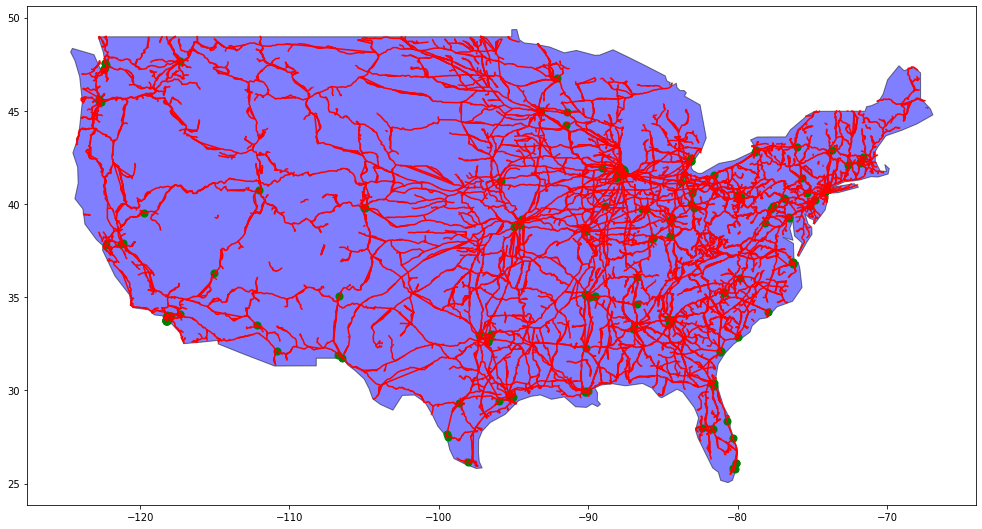

In [131]:
map_limit_poly = Polygon([(-140, 20), (-140, 50), (-60, 50), (-60, 20)])
map_limit = gpd.GeoDataFrame([1], geometry=[map_limit_poly], crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["name"] == "United States of America"]

fig, ax = plt.subplots(figsize=(17,10))
n_america_clipped = gpd.clip(n_america, map_limit)
n_america_clipped.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)
shp_lines_clipped = gpd.clip(shp_lines_relevant_cleaned, map_limit)
shp_lines_clipped.plot(ax=ax, color="red")
shp_nodes_relevant_cleaned[shp_nodes_relevant_cleaned.FRANODEID<300].plot(ax=ax, color="green",markersize=50)

In [94]:
G = nx.from_pandas_edgelist(shp_lines_relevant_cleaned, 
                            source='FRFRANODE', 
                            target='TOFRANODE',
                            edge_attr="KM",
                            create_using=nx.Graph() )

In [95]:
def plot_get_degree_dist(links_df, table = False):
    
    G = nx.from_pandas_edgelist(links_df, source='FRFRANODE', target='TOFRANODE')
    degree_sequence = sorted([d for n, d in G.degree()], reverse=False)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.70, color="b")

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    for i, v in enumerate(cnt):
        ax.text(i+0.95, v + .9, str(v), color='blue')
    ax.set_xticklabels(deg)
    
    if table:
        print(pd.DataFrame({'deg':deg, 'cnt':cnt}))

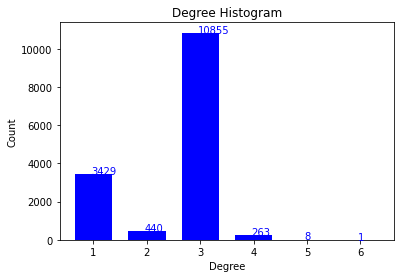

In [96]:
plot_get_degree_dist(shp_lines_relevant_cleaned)

One can clearly identify the degree distribution as following a poinsson distruibution (before cleaning the two degree nodes this observation was even more obvious). The USA rail network thus has the properties of a **random network**.

In [97]:
L = 0
for node,d in G.degree(): 
    L += d/2
N = len(list(G.nodes()))
k_avg = 2*L/N
print(f'Network properties: \n -number of links (L): {int(L)} \n -number of nodes (N): {N} \n -average degree (k_avg): {k_avg}' )

Network properties: 
 -number of links (L): 18986 
 -number of nodes (N): 14996 
 -average degree (k_avg): 2.532141904507869


In [98]:
connected_bool = nx.is_connected(G)
connected_components = nx.number_connected_components(G)
print(f'The network is connected: {connected_bool} \nIt has {connected_components} components')

The network is connected: False 
It has 74 components


Text(0.5, 1.0, 'connected components size')

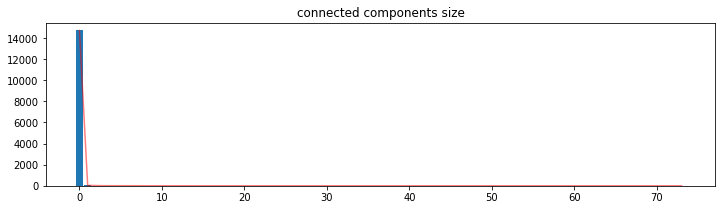

In [106]:
component_size = sorted([len(component) for component in nx.connected_components(G)], reverse=True)
fig, ax = plt.subplots(figsize=(12,3))
plt.bar(range(len(component_size)),component_size)
plt.plot(range(len(component_size)),component_size,color='red',alpha=0.5)
plt.title('connected components size')

One can clearly observe that there is one giant component. The other components are due to some auxiliary networks but their size is negligible. As an example, the second largest component (37 nodes) is situated in Alaska.